# Can Dilia be a youth?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

In [3]:
# my worspace and directories

path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'

In [4]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

In [5]:
# Load data v7 with images from pubnote

inputpath = '/fast_scratch/atlas_images/v7/'
rootfiles = ["pi0", "piplus", "piminus"]

#setupPionData(inputpath, rootfiles, branches = []) on ml_util with defaultBranches from ClusterTree
trees, pdata = mu.setupPionData(inputpath, rootfiles)

In [6]:
# pdata -> Dictionary of dataframes. "pi0", "piplus", "piminus" are separated inside of the dictionary

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [7]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [8]:
# * PRINTING *
# pcells is a dictionary of dictionaries of arrays with keys 'pi0','piplus'and 'piminus' 
#that has the layers as keys: EMB1, EMB2, EMB3, TileBar0, TileBar1, TileBar2 defined on cell_meta
#with dimension of the arrays as len_phi x len_eta

#print(pcells['pi0']['TileBar0']) #neutral pions some no zero values on first TileBar

In [9]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

In [10]:
import tensorflow as tf

In [11]:
##For taking multiple gpus:
#gpu_list = ["/gpu:0","/gpu:1"]
#strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
#ngpu = strategy.num_replicas_in_sync
#print ('Number of devices: {}'.format(ngpu))

In [12]:
## let's just take one gpu:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [13]:
##Other Trial ( "ValueError: Memory growth cannot differ between GPU devices" ) 
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [14]:
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
# merge pi0 and pi+ events
training_classes = ['pi0','piplus']
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)


#pcells_merged -> huge nympy array with all pi0 first and then all pi+ data
#A numpy arraw like this will remove all entries that are not true: pdata_merged.train
#plabels -> which ones are pions plus or pi zero. 

In [15]:
# * PRINTING *

for p_index, plabel in enumerate(training_classes):
    print(" ********************************** p_index: ", p_index, ", plabel: ", plabel)

#pdata after createTrainingDatasets get a 'label' 0 if pi0 
#print(pdata['pi0']['label']==0)
print(pdata['piplus']['label']==1)


 ********************************** p_index:  0 , plabel:  pi0
 ********************************** p_index:  1 , plabel:  piplus
0         True
1         True
2         True
3         True
4         True
          ... 
435962    True
435963    True
435964    True
435965    True
435966    True
Name: label, Length: 435967, dtype: bool


In [16]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16), layers=['EMB2', 'EMB3']),last=True)

In [17]:
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (128, 4), layers=['EMB1']),last=True)

In [18]:
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [19]:
def merged_model(droprate=.5):
    # EMB1 image (convolutional)
    input1 = Input(shape=(128,4,1), name='emb1_input')
    x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_1')(input1)
    x1 = Activation('relu')(x1)
    # x1 = Dropout(droprate)(x1)
    x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_2')(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_3')(x1)
    x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_3')(x1)
    x1 = Activation('relu')(x1)
    #x1 = Dropout(droprate)(x1)
    x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_4')(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_5')(x1)
    x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_6')(x1)
    x1 = Activation('relu')(x1)
    x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_7')(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_8')(x1)
    x1 = Dropout(droprate, name='emb1_dropout_4')(x1)
    x1 = Flatten(name='emb1_flatten_9')(x1)
    x1 = Dense(128, activation='relu', name='emb1_dense_9')(x1)

    # EMB23 image (convolutional)
    input2 = Input(shape=(16,16,2), name='emb23_input')
    x2 = Convolution2D(32, (1, 1), padding='same', name='emb23_conv1d_1')(input2)
    x2 = Activation('relu')(x2)
    # x2 = Dropout(droprate)(x2)
    x2 = Convolution2D(64, (2, 2), padding='same', name='emb23_conv2d_2')(x2)
    # x2 = Dropout(droprate)(x2)
    x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_3')(x2)
    x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_4')(x2)
    x2 = Activation('relu')(x2)
    # x2 = Dropout(droprate)(x2)
    x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_5')(x2)
    x2 = Activation('relu')(x2)
    x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_6')(x2)
    x2 = Dropout(droprate, name='emb23_dropout_4')(x2)
    x2 = Flatten(name='emb23_flatten_7')(x2)
    x2 = Dense(128, activation='relu', name='emb23_dense_8')(x2)

    # tiles image (convolutional)
    input3 = Input(shape=(4,4,3), name='tiles_input')
    x3 = Convolution2D(32, (1, 1), padding='same', name='tiles_conv1d_1')(input3)
    x3 = Activation('relu')(x3)
    # x3 = Dropout(droprate)(x3)
    x3 = Convolution2D(64, (2, 2), padding='same', name='tiles_conv2d_2')(x3)
    x3 = Activation('relu')(x3)
    # x3 = Dropout(droprate)(x3)
    x3 = Convolution2D(128, (2, 2), padding='same', name='tiles_conv2d_3')(x3)
    x3 = Activation('relu')(x3)
    x3 = MaxPool2D(pool_size=(2, 2), padding='same', name='tiles_maxpool_4')(x3)
    x3 = Dropout(droprate, name='tiles_dropout_4')(x3)
    x3 = Flatten(name='tiles_flatten_5')(x3)
    x3 = Dense(128, activation='relu', name='tiles_dense_6')(x3)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2, x3], name='concatenate') 
    x = Dropout(droprate, name='concate_dropout_5')(x)
    x = Dense(64, name='concated_dense_1')(x)    
    x = Activation('relu')(x)
    x = Dropout(droprate, name='dense_dropout_6')(x)

    # final output
    output = Dense(2, activation='softmax', name='dense_output')(x)
    # output = 5*tf.math.tanh(x)   # 0 to +5 range

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    # compile model
    # model = multi_gpu_model(model, gpus=4)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
model_p1_d02 = merged_model(0.2)

In [21]:
#history_p1_d02 = model_p1_d02.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
#                                pcellsE23_EMB2G_channels[pdata_merged.train], 
#                                pcellsT123_T1G_channels[pdata_merged.train]],
#                                plabels[pdata_merged.train],
#                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
#                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
#                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
#                                                    plabels[pdata_merged.val]),
#                                epochs=50,
#                                batch_size = 128,     #*ngpu,
#                                verbose=2
#                                # use_multiprocessing=False
#                                )

In [22]:
##### Testing less epochs than 250
history_p1_d02 = model_p1_d02.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
                                pcellsE23_EMB2G_channels[pdata_merged.train], 
                                pcellsT123_T1G_channels[pdata_merged.train]],
                                plabels[pdata_merged.train],
                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
                                                    plabels[pdata_merged.val]),
                                epochs = 100,
                                batch_size = 128,
                                verbose=2
                                # use_multiprocessing=False
                                )

Epoch 1/100
3828/3828 - 62s - loss: 0.2394 - accuracy: 0.9074 - val_loss: 0.1941 - val_accuracy: 0.9283
Epoch 2/100
3828/3828 - 45s - loss: 0.1983 - accuracy: 0.9268 - val_loss: 0.1884 - val_accuracy: 0.9299
Epoch 3/100
3828/3828 - 44s - loss: 0.1906 - accuracy: 0.9302 - val_loss: 0.1785 - val_accuracy: 0.9341
Epoch 4/100
3828/3828 - 44s - loss: 0.1858 - accuracy: 0.9321 - val_loss: 0.1733 - val_accuracy: 0.9356
Epoch 5/100
3828/3828 - 44s - loss: 0.1818 - accuracy: 0.9331 - val_loss: 0.1763 - val_accuracy: 0.9356
Epoch 6/100
3828/3828 - 44s - loss: 0.1794 - accuracy: 0.9343 - val_loss: 0.1733 - val_accuracy: 0.9364
Epoch 7/100
3828/3828 - 43s - loss: 0.1768 - accuracy: 0.9350 - val_loss: 0.1717 - val_accuracy: 0.9370
Epoch 8/100
3828/3828 - 44s - loss: 0.1753 - accuracy: 0.9361 - val_loss: 0.1704 - val_accuracy: 0.9389
Epoch 9/100
3828/3828 - 44s - loss: 0.1736 - accuracy: 0.9368 - val_loss: 0.1653 - val_accuracy: 0.9389
Epoch 10/100
3828/3828 - 44s - loss: 0.1720 - accuracy: 0.9372 -

* Plotting!!!! 

<Figure size 799.992x599.976 with 0 Axes>

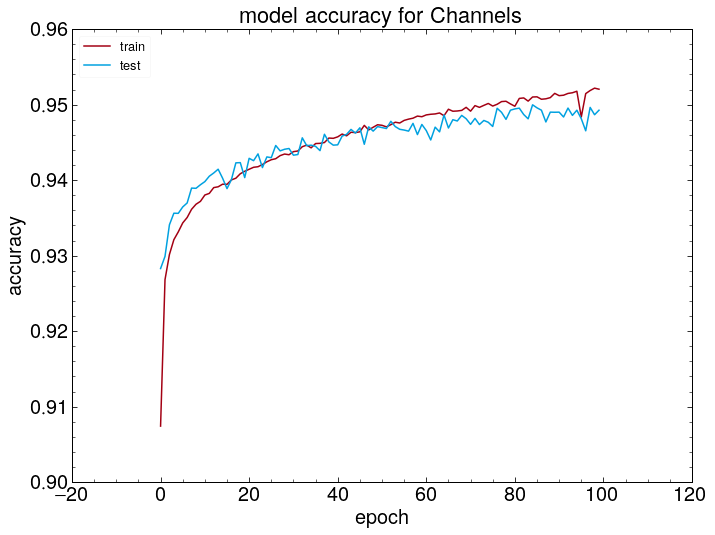

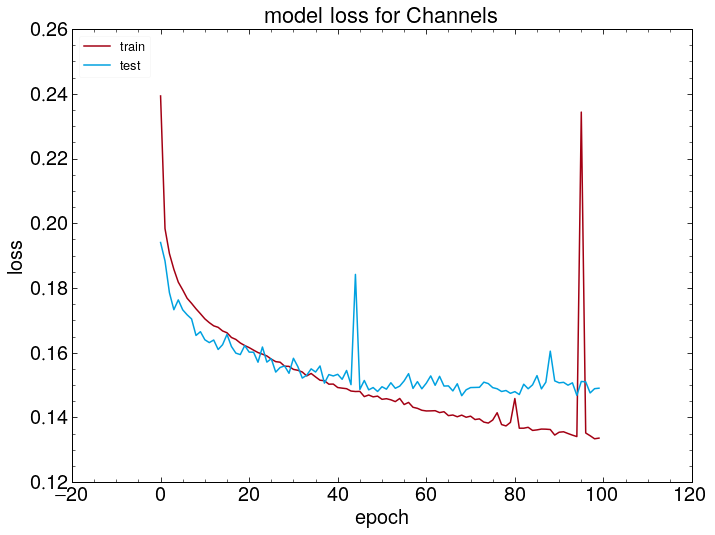

In [28]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_p1_d02.history['accuracy'])
plt.plot(history_p1_d02.history['val_accuracy'])
plt.title('model accuracy for Channels')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_epochs100_v2.pdf')
plt.show()

    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_p1_d02.history['loss'])
plt.plot(history_p1_d02.history['val_loss'])
plt.title('model loss for Channels')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plotpath + 'loss_epochs100_v2.pdf')
plt.show()

In [29]:
model_p1_d02.save(modelpath+'model_p1_d02_v2.h5')
scores_p1_d02 = model_p1_d02.predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels])

In [25]:
model_p1_d02.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb1_input (InputLayer)         [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
emb1_conv2d_1 (Conv2D)          (None, 128, 4, 32)   320         emb1_input[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 4, 32)   0           emb1_conv2d_1[0][0]              
__________________________________________________________________________________________________
emb1_conv2d_2 (Conv2D)          (None, 128, 4, 32)   9248        activation[0][0]                 
______________________________________________________________________________________________

In [26]:
from sklearn.metrics import roc_curve, auc
roc_fpr_p1_d02, roc_tpr_p1_d02, roc_thresh_p1_d02 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_p1_d02[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_p1_d02 = auc(roc_fpr_p1_d02, roc_tpr_p1_d02)
print('Area under curve for CNN p1_d02 ' + str(roc_auc_p1_d02))

Area under curve for CNN p1_d02 0.9862257554363169


With 100 ephocs v1: Area under curve for CNN p1_d02 0.9863198848439804

With 250 ephocs: Area under curve for CNN p1_d02 0.9898192961620463

# Classification plots?

In [30]:
varlist = []
cluster_e = pu.rocVar(
    name='clusterE',
    bins=[1,10,50,500],
    df=pdata_merged,
    latex='Cluster E',
    vlist=varlist,
)

In [39]:
print(scores_p1_d02[:,1].shape)

(699858,)


<Figure size 799.992x599.976 with 0 Axes>

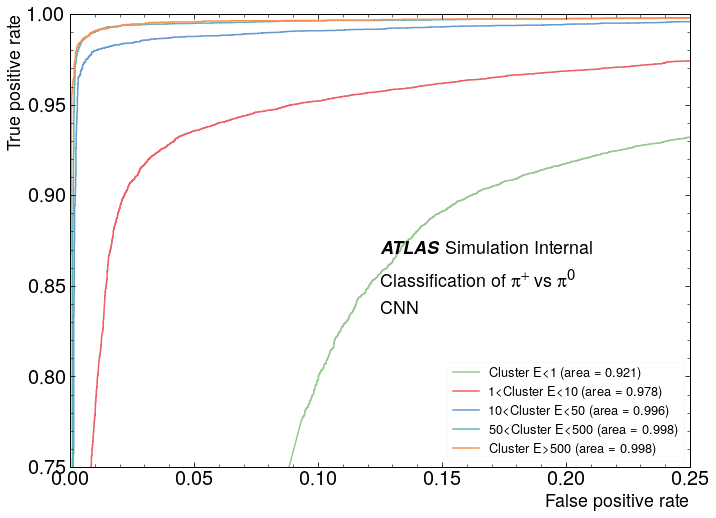

In [48]:
pu.rocScan(varlist, [scores_p1_d02[:,1]], ['CNN'], plabels, pdata_merged, 
            plotpath=  plotpath+ 'CNN_epochs100_v2_roc_zoom.pdf',
            x_min = 0.0, x_max = 0.25, y_min = 0.75, y_max = 1.0,
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'},
                        {'x': 0.5, 'y': 0.34, 'text': 'CNN '}])

/home/dportill/LCStudies/util/plot_util.py:267: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(y, 1. / x, label=label +
/home/dportill/LCStudies/util/plot_util.py:267: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(y, 1. / x, label=label +
/home/dportill/LCStudies/util/plot_util.py:267: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(y, 1. / x, label=label +
/home/dportill/LCStudies/util/plot_util.py:267: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(y, 1. / x, label=label +
/home/dportill/LCStudies/util/plot_util.py:267: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(y, 1. / x, label=label +


<Figure size 799.992x599.976 with 0 Axes>

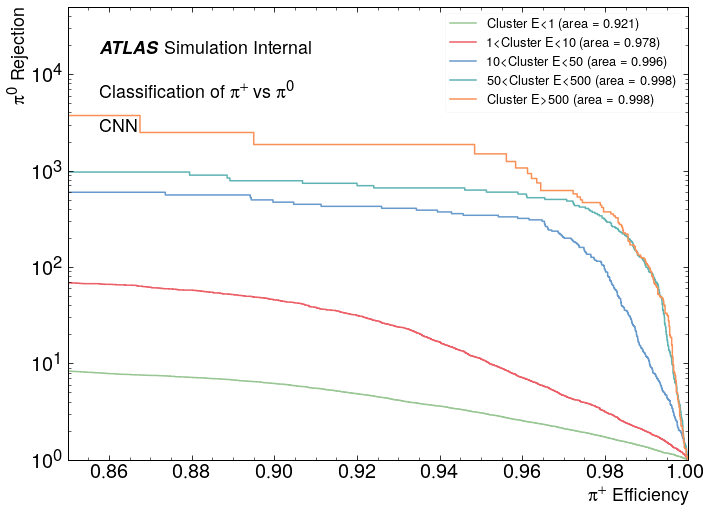

In [71]:
pu.rocScan(varlist, [scores_p1_d02[:,1]], ['CNN '], plabels, pdata_merged, 
            plotpath=  plotpath+ 'CNN_epochs100_v2_roc_rejection.pdf',
            x_min = 0.85, x_max = 1.0, y_min = 1, y_max = 50000, 
            x_log = False, y_log = True, rejection = True, x_label = '$\pi^{+}$ Efficiency', y_label = '$\pi^{0}$ Rejection',
            atlas_x = 0.05, atlas_y = 0.925, simulation = True,
            textlist = [{'x': 0.05, 'y': 0.8, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'},
                        {'x': 0.05, 'y': 0.725, 'text': 'CNN '}])

/home/dportill/LCStudies/util/plot_util.py:353: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(x, 1. / y, label=label, linestyle=linestyle, color=color, linewidth=3)
/home/dportill/LCStudies/util/plot_util.py:353: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(x, 1. / y, label=label, linestyle=linestyle, color=color, linewidth=3)


TypeError: drawLabels() got an unexpected keyword argument 'atlas_status'

<Figure size 799.992x599.976 with 0 Axes>

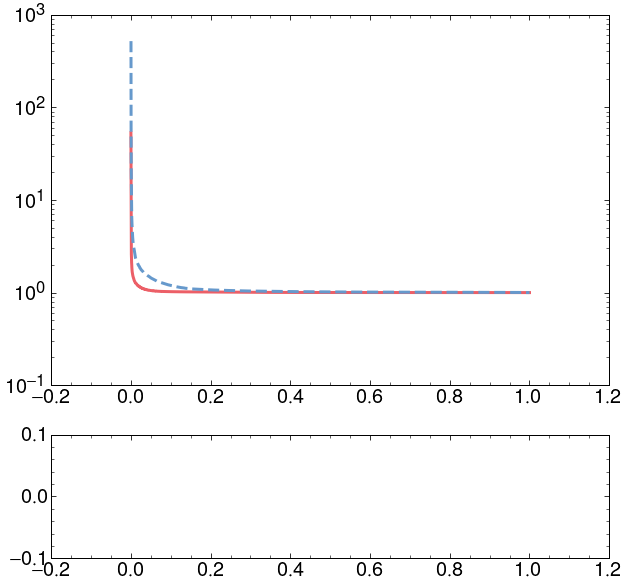

In [72]:
pu.roc_plot_scores([ 1-scores_p1_d02[:,1], pdata_merged.cluster_EM_PROBABILITY.to_numpy()], plabels, pdata_merged, 
            figfile = plotpath+'model_compare.pdf',
            labels = ['CNN', 'LC EMProb'],
            x_min = 0.925, x_max = 1.0, y_min = 1, y_max = 1000, 
            x_log = False, y_log = True, rejection = True, 
            x_label = '$\pi^{+}$ Efficiency', y_label = '$\pi^{0}$ Rejection',
            atlas_x = 0.05, atlas_y = 0.925, simulation = True,
            linestyles = ['-','--','-.',':'], colorgrouping = -1,
            textlist = [{'x': 0.05, 'y': 0.8, 'text': 'Classification of $\pi^{+}$ vs $\pi^{0}$'}])

LETS TRY WITH 150 ephocs!!

In [27]:
#history_p1_d02_150 = model_p1_d02.fit([pcellsE1_EMB1G_channels[pdata_merged.train], 
#                                pcellsE23_EMB2G_channels[pdata_merged.train], 
#                                pcellsT123_T1G_channels[pdata_merged.train]],
#                                plabels[pdata_merged.train],
#                                validation_data=([pcellsE1_EMB1G_channels[pdata_merged.val], 
#                                                    pcellsE23_EMB2G_channels[pdata_merged.val], 
#                                                    pcellsT123_T1G_channels[pdata_merged.val]], 
#                                                    plabels[pdata_merged.val]),
#                                epochs=150,
#                                batch_size = 128,
#                                verbose=2
#                                # use_multiprocessing=False
#                                )